In [11]:
## Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import patsy
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import math

from IPython.display import display, HTML
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
## Read in Data
flight = pd.read_csv("flight.csv")

## Melt dataframe
melted_flight = pd.melt(
    frame=flight, 
    id_vars=['miles', 'passengers', 'delay', 'inflight_meal', 'inflight_entertainment',
             'inflight_wifi', 'day_of_week', 'redeye', 'weekend', 'hours'],
    value_vars=['coach_price', 'firstclass_price'], 
    var_name='seat_type', 
    value_name='price')
display(HTML(melted_flight[-10:].to_html()))

,miles,passengers,delay,inflight_meal,inflight_entertainment,inflight_wifi,day_of_week,redeye,weekend,hours,seat_type,price
259550,1229,211,1491,Yes,Yes,Yes,Friday,No,Yes,2,firstclass_price,1581.12
259551,4168,212,1468,No,Yes,No,Friday,No,Yes,8,firstclass_price,1633.78
259552,1440,208,1490,Yes,Yes,Yes,Friday,No,Yes,3,firstclass_price,1582.13
259553,2488,204,1503,No,Yes,Yes,Tuesday,No,No,5,firstclass_price,1335.66
259554,3806,211,1510,No,Yes,Yes,Sunday,No,Yes,7,firstclass_price,1641.50
259555,674,217,1487,No,Yes,Yes,Friday,No,Yes,1,firstclass_price,1478.70
259556,2125,208,1479,No,Yes,Yes,Friday,No,Yes,4,firstclass_price,1616.01
259557,1702,220,1501,No,Yes,Yes,Friday,No,Yes,3,firstclass_price,1481.49
259558,2709,205,1484,No,Yes,Yes,Saturday,No,Yes,5,firstclass_price,1589.70
259559,4005,214,1490,No,Yes,Yes,Saturday,No,Yes,7,firstclass_price,1677.54


### Part 1: Distributions of Data

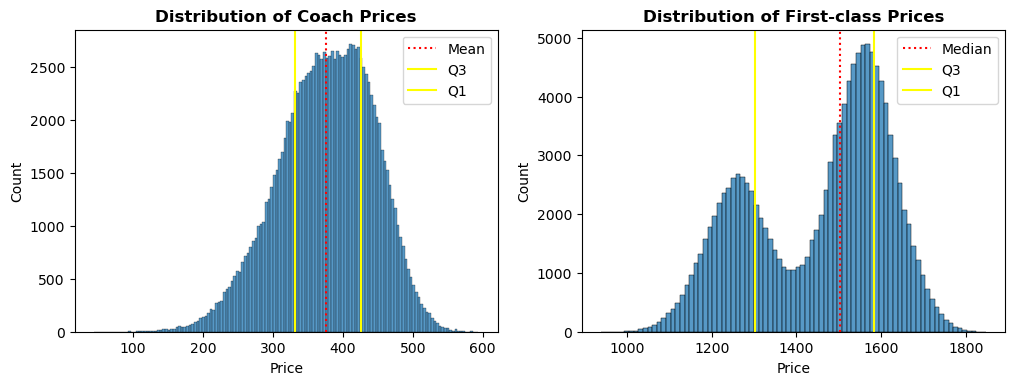

<Figure size 432x288 with 0 Axes>

In [3]:
## Plot a histogram for the distribution of Coach prices
plt.figure(figsize=(12,4), dpi=100)
plt.subplot(1,2,1)
ax = sns.histplot(data=melted_flight.price[melted_flight.seat_type == 'coach_price'])
ax.set_title('Distribution of Coach Prices', weight='bold')
ax.set_xlabel('Price')
ax.set_ylabel('Count')
plt.axvline(
    melted_flight.price[melted_flight.seat_type == 'coach_price'].mean(),
    linestyle=':', color='red', label='Mean')
plt.axvline(
    np.quantile(melted_flight.price[melted_flight.seat_type == 'coach_price'], 0.75),
    color='yellow', label='Q3')
plt.axvline(
    np.quantile(melted_flight.price[melted_flight.seat_type == 'coach_price'], 0.25),
    color='yellow', label='Q1')
plt.legend()

## Plot a histogram for the distribution of First-class prices
plt.subplot(1,2,2)
ax2 = sns.histplot(data=melted_flight.price[melted_flight.seat_type == 'firstclass_price'])
ax2.set_title('Distribution of First-class Prices', weight='bold')
ax2.set_xlabel('Price')
ax2.set_ylabel('Count')
plt.axvline(
    melted_flight.price[melted_flight.seat_type == 'firstclass_price'].median(),
    linestyle=':', color='red', label='Median')
plt.axvline(
    np.quantile(melted_flight.price[melted_flight.seat_type == 'firstclass_price'], 0.75),
    color='yellow', label='Q3')
plt.axvline(
    np.quantile(melted_flight.price[melted_flight.seat_type == 'firstclass_price'], 0.25),
    color='yellow', label='Q1')
plt.legend()
plt.show()
plt.clf()

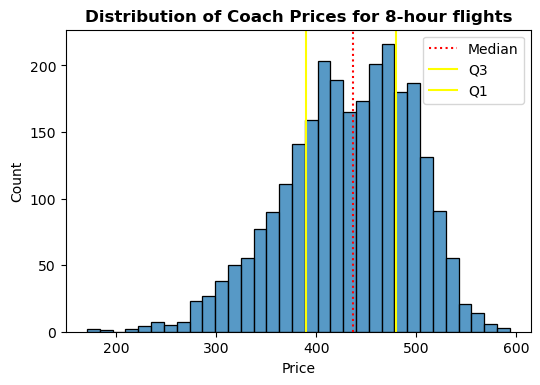

<Figure size 432x288 with 0 Axes>

In [4]:
## Plot a histogram for the distribution of prices of 8-hour flights
plt.figure(figsize=(6,4), dpi=100)
flight_8hrs = melted_flight.loc[melted_flight.hours == 8]
ax2 = sns.histplot(data=flight_8hrs.price[flight_8hrs.seat_type == 'coach_price'])
ax2.set_title('Distribution of Coach Prices for 8-hour flights', weight='bold')
ax2.set_xlabel('Price')
ax2.set_ylabel('Count')
plt.axvline(
    flight_8hrs.price[flight_8hrs.seat_type == 'coach_price'].median(),
    linestyle=':', color='red', label='Median')
plt.axvline(
    np.quantile(flight_8hrs.price[flight_8hrs.seat_type == 'coach_price'], 0.75),
    color='yellow', label='Q3')
plt.axvline(
    np.quantile(flight_8hrs.price[flight_8hrs.seat_type == 'coach_price'], 0.25),
    color='yellow', label='Q1')
plt.legend()
plt.show()
plt.clf()

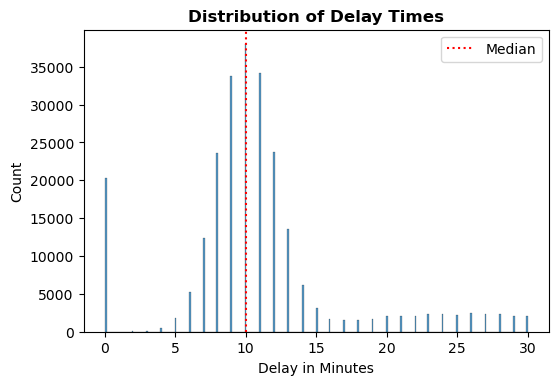

<Figure size 432x288 with 0 Axes>

In [5]:
## Plot a histogram for the distribution of delay times
plt.figure(figsize=(6,4), dpi=100)
ax3 = sns.histplot(data=melted_flight.delay[melted_flight.delay <= 30])
ax3.set_title('Distribution of Delay Times', weight='bold')
ax3.set_xlabel('Delay in Minutes')
ax3.set_ylabel('Count')
plt.axvline(flight.delay.median(), linestyle=':', color='red', label='Median')
plt.legend()
plt.show()
plt.clf()

### Part 2: Visualizing associations between attributes

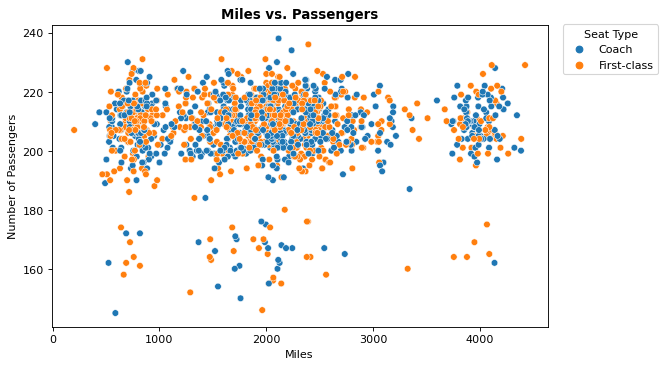

<Figure size 432x288 with 0 Axes>

In [6]:
## Plot a scatter plot: miles vs passenger
perc=0.005
flight_sub = melted_flight.sample(n=int(melted_flight.shape[0]*perc))

plt.figure(figsize=(8,5), dpi=80)
sns.scatterplot(x='miles', y='passengers', hue='seat_type', data=flight_sub)
plt.title('Miles vs. Passengers', weight='bold')
plt.xlabel('Miles')
plt.ylabel('Number of Passengers')
L = plt.legend(title='Seat Type', bbox_to_anchor=(1.02, 1.02))
L.get_texts()[0].set_text('Coach')
L.get_texts()[1].set_text('First-class')
plt.show()
plt.clf()

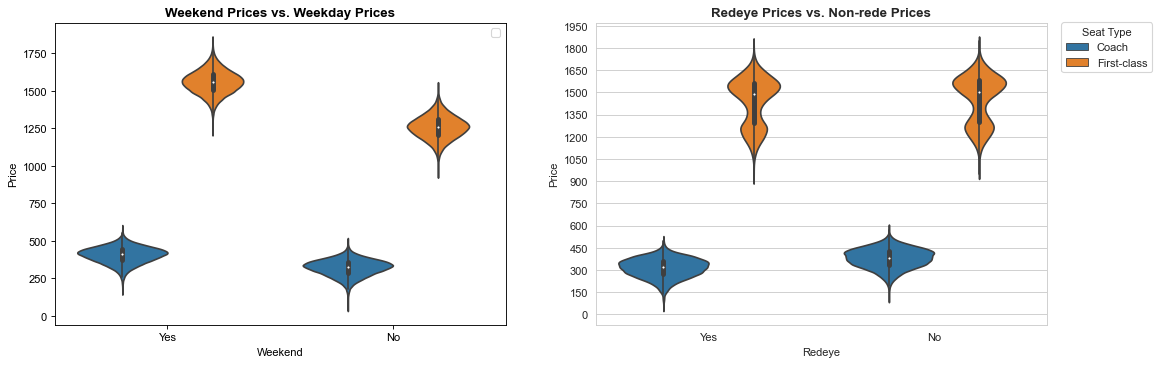

<Figure size 432x288 with 0 Axes>

In [7]:
## Plot violin plots to compare the difference in weekend prices and weekday prices
plt.figure(figsize=(16,5), dpi=80)
plt.subplot(1,2,1)
sns.set_style('whitegrid')
sns.violinplot(x='weekend', y='price', hue='seat_type', data=melted_flight)
plt.title('Weekend Prices vs. Weekday Prices', weight='bold')
plt.xlabel('Weekend')
plt.ylabel('Price')
plt.legend('')

## Plot violin plots to compare the difference in weekend prices and weekday prices
plt.subplot(1,2,2)
sns.set_style('whitegrid')
sns.violinplot(x='redeye', y='price', hue='seat_type', data=melted_flight)
plt.title('Redeye Prices vs. Non-rede Prices', weight='bold')
plt.xlabel('Redeye')
plt.ylabel('Price')
plt.yticks(range(0, 2000, 150))
L = plt.legend(title='Seat Type', bbox_to_anchor=(1.02, 1.02))
L.get_texts()[0].set_text('Coach')
L.get_texts()[1].set_text('First-class')

plt.show()
plt.clf()

### Part 3: Linear Regression Model to analyze and predict ticket prices

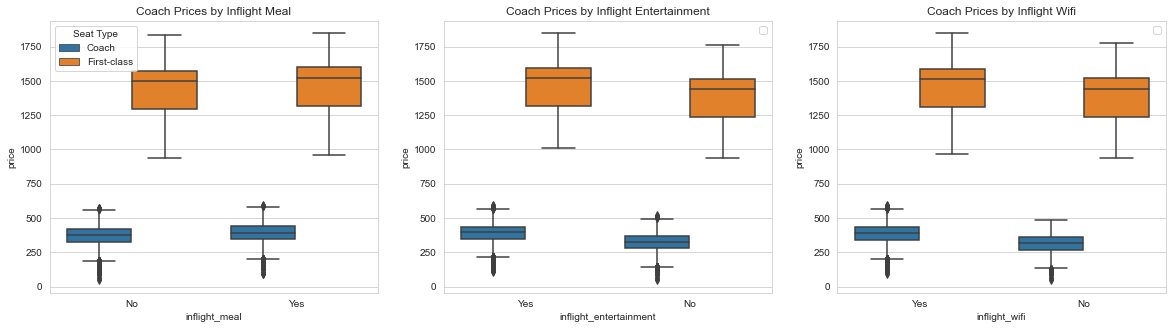

<Figure size 432x288 with 0 Axes>

In [8]:
## Plot box plots to visulize the relationship between prices and flight features
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
sns.boxplot(x='inflight_meal', y='price', hue='seat_type', data=melted_flight)
plt.title('Coach Prices by Inflight Meal')
L = plt.legend(title='Seat Type')
L.get_texts()[0].set_text('Coach')
L.get_texts()[1].set_text('First-class')
plt.subplot(1,3,2)
sns.boxplot(x='inflight_entertainment', y='price', hue='seat_type', data=melted_flight)
plt.title('Coach Prices by Inflight Entertainment')
plt.legend('')
plt.subplot(1,3,3)
plt.title('Coach Prices by Inflight Wifi')
sns.boxplot(x='inflight_wifi', y='price', hue='seat_type', data=melted_flight)
plt.legend('')
plt.show()
plt.clf()

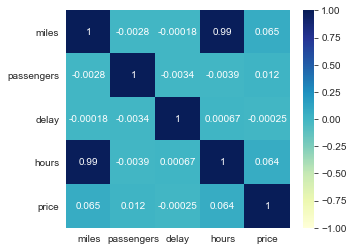

<Figure size 432x288 with 0 Axes>

In [9]:
## Build a OLS model to analyze the association between different attributes and prices
plt.figure(figsize=(5,4))
corr_grid = melted_flight.corr()
sns.heatmap(
    corr_grid, 
    xticklabels=corr_grid.columns, 
    yticklabels=corr_grid.columns, 
    vmin=-1, center=0, vmax=1, annot=True, cmap='YlGnBu')
plt.show()
plt.clf()

As shown on the heatmap, `miles` and `hours` are strongly correlated. To avoid multicolinerity, these two varibles should not be used together.

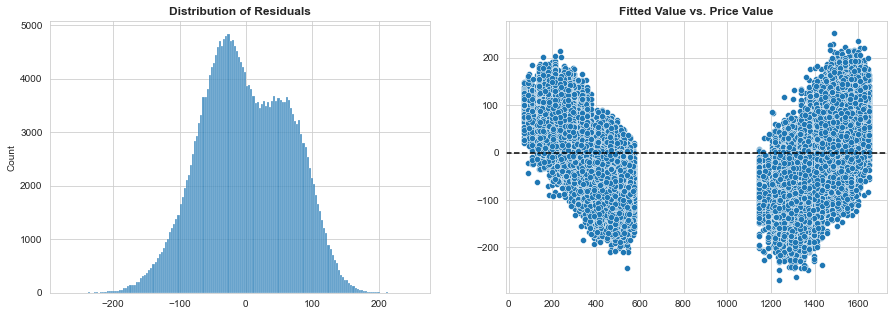

0.981589857716026 0.9855204531110964
2978599.7054836284 2916274.0409301887
-1489231.2856543863 -1458062.220006082


<Figure size 432x288 with 0 Axes>

In [25]:
model1 = sm.OLS.from_formula(
    'price ~ inflight_meal + inflight_entertainment + inflight_wifi + day_of_week + seat_type',
    data=melted_flight).fit()

model2 = sm.OLS.from_formula(
    'price ~ inflight_meal + inflight_entertainment + inflight_wifi + day_of_week + seat_type + hours',
    data=melted_flight).fit()

## Build the same `model2` using sklearn
# y, X = patsy.dmatrices(
#     'price ~ inflight_meal + inflight_entertainment + inflight_wifi + day_of_week + seat_type + hours',
#     data=melted_flight)
# model3 = LinearRegression().fit(X,y)

## Check OLS Model Assumptions: PASSED
fitted_value = model2.predict(melted_flight)
residuals = melted_flight.price - fitted_value

## Check the Normality Assumption and Homoscedasticity Assumption
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(residuals)
plt.title('Distribution of Residuals', weight='bold')
plt.subplot(1,2,2)
sns.scatterplot(fitted_value, residuals)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.title('Fitted Value vs. Price Value', weight='bold')
plt.show()
plt.clf()

## R-squared
print(model1.rsquared_adj, model2.rsquared_adj)

## BIC
print(model1.bic, model2.bic)

## Log-likelyhood
print(model1.llf, model2.llf)

Based on the tests, `model2` is chosen to be the best OLS linear regression sofar.

In [15]:
display(HTML(melted_flight[-10:].to_html()))

,miles,passengers,delay,inflight_meal,inflight_entertainment,inflight_wifi,day_of_week,redeye,weekend,hours,seat_type,price
259550,1229,211,1491,Yes,Yes,Yes,Friday,No,Yes,2,firstclass_price,1581.12
259551,4168,212,1468,No,Yes,No,Friday,No,Yes,8,firstclass_price,1633.78
259552,1440,208,1490,Yes,Yes,Yes,Friday,No,Yes,3,firstclass_price,1582.13
259553,2488,204,1503,No,Yes,Yes,Tuesday,No,No,5,firstclass_price,1335.66
259554,3806,211,1510,No,Yes,Yes,Sunday,No,Yes,7,firstclass_price,1641.50
259555,674,217,1487,No,Yes,Yes,Friday,No,Yes,1,firstclass_price,1478.70
259556,2125,208,1479,No,Yes,Yes,Friday,No,Yes,4,firstclass_price,1616.01
259557,1702,220,1501,No,Yes,Yes,Friday,No,Yes,3,firstclass_price,1481.49
259558,2709,205,1484,No,Yes,Yes,Saturday,No,Yes,5,firstclass_price,1589.70
259559,4005,214,1490,No,Yes,Yes,Saturday,No,Yes,7,firstclass_price,1677.54


In [24]:
## Test prediction manually
test_price = model2.predict({'inflight_meal':'No', 'inflight_entertainment':'Yes', 'inflight_wifi':'Yes', 'day_of_week':'Saturday', 'seat_type':'firstclass_price', 'hours':7})
print(test_price)

0    1606.50336
dtype: float64
